<a href="https://colab.research.google.com/github/AlinaZdrengheaAI/MAI/blob/main/CNN_Chest_X_Ray_Pneumonia_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Pneumonia?

Pneumonia is a lung infection that can range from mild to so severe that you have to go to the hospital. It happens when an infection causes the air sacs in your lungs (your doctor will call them alveoli) to fill with fluid or pus. That can make it hard for you to breathe in enough oxygen to reach your bloodstream.

Anyone can get this lung infection. But infants younger than age 2 and people over age 65 are at higher risk. That’s because their immune systems might not be strong enough to fight it. You can get pneumonia in one or both lungs. You can also have it and not know it. Doctors call this walking pneumonia. Causes include bacteria, viruses, and fungi.  If your pneumonia results from bacteria or a virus, you can spread it to someone else.

Lifestyle habits, like smoking cigarettes and drinking too much alcohol, can also raise your chances of getting pneumonia.

## Symptoms of Pneumonia

Your symptoms can vary depending on what’s causing your pneumonia, your age, and your overall health. They usually develop over several days.
Common pneumonia symptoms include:

1. Chest pain when you breathe or cough
2. Cough that produces phlegm or mucus
3. Fatigue and loss of appetite
4. Fever, sweating, and chills
5. Nausea, vomiting, and diarrhea
6. Shortness of breath
7. Along with these symptoms, older adults and people with weak immune systems might be confused or have changes in mental awareness, or they might have a lower-than-usual body temperature.

Newborns and infants may not show any signs of infection. Or they might vomit, have a fever and a cough, and seem restless or tired. If you have a new cough, fever, or shortness of breath, call your doctor to ask about whether it could be COVID-19. Illness with the new coronavirus can also lead to pneumonia.

# Objective of the Notebook

In this Notebook we will be creating a model to identify whether a patient is having Pneumonia from the X-Ray image of their chest. In the medical science field, doctors need to diagnose if the patient is having pneumonia, and the X-Ray image is one of the major form of reference for the same. If with the help of Data Science, we shall be able to create a model that actually helps them to spot out the cases, then we will be helping them out with faster diagnosis of the illness.

# Importing the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
import pandas as pd
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from google.colab import drive
import tqdm

# Description of the Pneumonia Dataset

![](https://images.medicinenet.com/images/article/main_image/pneumonia-3.jpg)

The dataset we recieved is actually distributed into 3 folders (train, test, val) and individually, they contain subfolders for each image category (Pneumonia/Normal).

There are a total of 5,863 X-Ray images (in JPEG Format) distributed into 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.
All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# Reading the Data Images

## Creating necesary functions to read and subsample the data

Because the dataset is massive we create a function to create a subsample of it to save computational resources and time

In [ ]:
def subsample_data(image_list, subsample_size_pct):
  if subsample_size_pct < 1.0:
    subsample_size = int(subsample_size_pct*len(image_list))
    index_list = list(range(len(image_list)))
    random.shuffle(index_list)
    index_values = random.sample(list(index_list), subsample_size)
    return [image_list[i] for i in index_values]
  else:
    return image_list

In [ ]:
img_size = 150
subsample_size_pct = 0.1

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
def get_training_data(data_dir, subsample_size_pct=0.1):
    data = []
    label_list = []
    for label in labels:
        print("LABEL: {}".format(label))
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        image_list = os.listdir(path)
        if "NORMAL" in label:
          image_list = subsample_data(image_list, subsample_size_pct*3)
        else:
          image_list = subsample_data(image_list, subsample_size_pct)
        #image_list = subsample_data(image_list, subsample_size_pct)
        for img in tqdm.tqdm(image_list):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append(resized_arr)
                label_list.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data), np.array(label_list)

## Mounting Gdrive to read the dataset

We must have the dataset uploaded to Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We set the Google Drive Path where we have out data set stored

In [ ]:
# Change this path
drive_path = "/content/drive/MyDrive/UAH_didactic_materials/medical_images/week_2/data/chest_xray"


## Loading and pre-procesing the Dataset

In [ ]:
print("TRAIN:")
X_train, y_train = get_training_data(os.path.join(drive_path, 'train'), subsample_size_pct=0.1)
print("TEST:")
X_test, y_test = get_training_data(os.path.join(drive_path, 'test'), subsample_size_pct=1)

TRAIN:
LABEL: PNEUMONIA


100%|██████████| 387/387 [00:07<00:00, 51.10it/s]


LABEL: NORMAL


100%|██████████| 402/402 [00:12<00:00, 31.17it/s]


TEST:
LABEL: PNEUMONIA


100%|██████████| 390/390 [00:04<00:00, 89.59it/s]


LABEL: NORMAL


100%|██████████| 234/234 [00:04<00:00, 48.51it/s]


In [ ]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Visualization

Let us try to see how well is the data distributed. Since we are working on a classification problem, if our data labels are not likewse distributed- the results will be highly biased too. This would not be something we want. Let us take a look into the data that we are using right now.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


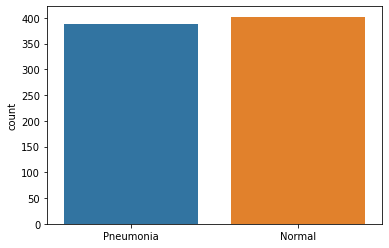

In [ ]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l)

**Observation** Clearly, the data seems to be imbalanced in this case.

Let us just take a look at a sample each of each class.

Text(0.5, 1.0, 'NORMAL')

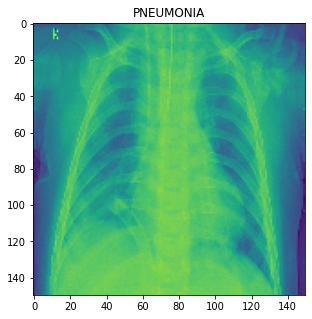

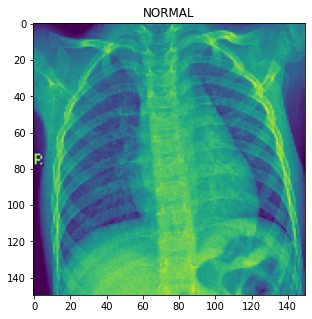

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X_train[0].reshape(150, 150), cmap='viridis')
plt.title(labels[y_train[0]])

plt.figure(figsize = (5,5))
plt.imshow(X_train[-1].reshape(150, 150), cmap='viridis')
plt.title(labels[y_train[-1]])

**Fact** An x-ray exam allows a doctor to see your lungs, heart and blood vessels to help determine if you have pneumonia. When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection. This exam will also help determine if you have any complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs).

Now obviously, as I am no doctor, I wont't be able to identify the ailment just by looking at the X-Ray. So I will just be creating a model to solve the problem.

Now based on the data we have ingested, its time to distribute them into the respective training, testing and validation groups. And using these values we will be implementing our model

# Image Normalization

Now in the images that we have, there might be instances where the range of illumination is too huge for processing. Like any other model, if a normalization factor is introduced, the model's ability to interpret the data becomes much better.

Likewise, a Convolution Neural Network will be much more efficient when the data is normalized.

In [ ]:
# Normalize the data
x_train = np.array(X_train) / 255
x_test = np.array(X_test) / 255

# Data Augmentation

### How do I get more data, if I don’t have “more data”?
You don’t need to hunt for novel new images that can be added to your dataset. Why? Because, neural networks aren’t smart to begin with. For instance, a poorly trained neural network would think that these three tennis balls shown below, are distinct, unique images.

![](https://nanonets.com/blog/content/images/2018/11/1_L07HTRw7zuHGT4oYEMlDig.jpeg)

These are actually tennis ball with different positions. The same tennis ball, but translated.

So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

![](https://nanonets.com/blog/content/images/2018/11/1_dJNlEc7yf93K4pjRJL55PA--1-.png)

Example of data augmentation application in deep learning layers

### Data Augmentation in play

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).

This essentially is the premise of data augmentation. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data.

In order words, to avoid overfitting problem, we need to artificially expand our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

![](https://static.javatpoint.com/tutorial/pytorch/images/pytorch-data-augmentation-process.png)

In [ ]:
data_generator = ImageDataGenerator(
                    featurewise_center=False,  # set input mean to 0 over the dataset
                    samplewise_center=False,  # set each sample mean to 0
                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                    samplewise_std_normalization=False,  # divide each input by its std
                    zca_whitening=False,  # apply ZCA whitening
                    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                    zoom_range = 0.1, # Randomly zoom image
                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                    horizontal_flip = True,  # randomly flip images
                    vertical_flip=False # randomly flip images
                )

In [ ]:
data_generator.fit(X_train)

For the data augmentation, I selected the following techniques :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 10% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally.

Once our model is ready, we will fit the training dataset.

# Training the Model

As discussed previously, we shall be working on the creation of a multilayer Convolution Neural Network, which will be responsible to parse through the images and provide us with an estimation if the image we are seeing is that of an infected patient or a normal patient.

![](https://analyticsindiamag.com/wp-content/uploads/2018/01/conv-full-layer.gif)

### Creating the Neural Network Model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))

model.add(Dense(units = 1 , activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_16 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 75, 75, 64)       256       
 chNormalization)                                                
                                                      

We can see the model structure built above.

Now we will start fitting out data into the model to estimate its accuracy. Initially, I am choosing 10 epochs for seeing the overall result. Lets find out the level of accuracy we reach.

## Fitting the Model

In [ ]:
history = model.fit(data_generator.flow(X_train,y_train, batch_size = 8) ,epochs = 20 , validation_data = data_generator.flow(X_test, y_test))

Epoch 1/20
99/99 [==============================] - 6s 47ms/step - loss: 1.6062 - accuracy: 0.7833 - val_loss: 1.0424 - val_accuracy: 0.3830
Epoch 2/20
99/99 [==============================] - 4s 44ms/step - loss: 0.5570 - accuracy: 0.7833 - val_loss: 0.4946 - val_accuracy: 0.7821
Epoch 3/20
99/99 [==============================] - 7s 74ms/step - loss: 0.3526 - accuracy: 0.8695 - val_loss: 0.3708 - val_accuracy: 0.8221
Epoch 4/20
99/99 [==============================] - 5s 47ms/step - loss: 0.3099 - accuracy: 0.8669 - val_loss: 0.3996 - val_accuracy: 0.8381
Epoch 5/20
99/99 [==============================] - 4s 44ms/step - loss: 0.2542 - accuracy: 0.9075 - val_loss: 1.7645 - val_accuracy: 0.4231
Epoch 6/20
99/99 [==============================] - 4s 44ms/step - loss: 0.2821 - accuracy: 0.8796 - val_loss: 0.7326 - val_accuracy: 0.6827
Epoch 7/20
99/99 [==============================] - 4s 44ms/step - loss: 0.2562 - accuracy: 0.9100 - val_loss: 1.7449 - val_accuracy: 0.4455
Epoch 8/20
99

# Checking the Results on the Test Data

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 23ms/step - loss: 0.7104 - accuracy: 0.7163
Loss of the model is -  0.710398256778717
20/20 [==============================] - 0s 23ms/step - loss: 0.7104 - accuracy: 0.7163
Accuracy of the model is -  71.63461446762085 %


# Analysis after Model Training

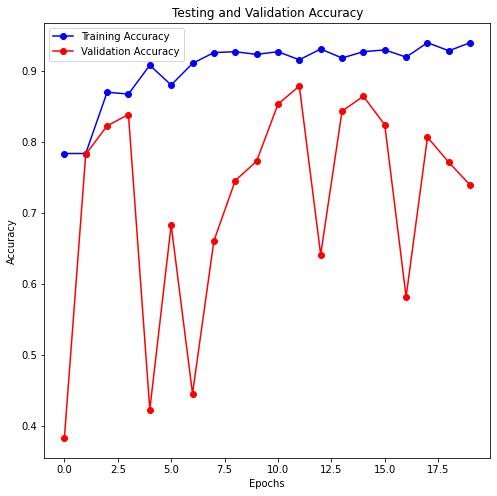

In [ ]:
epochs = [i for i in range(20)]
plt.figure(figsize=(8,8))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs , train_acc , 'b-o' , label = 'Training Accuracy')
plt.plot(epochs , val_acc , 'r-o' , label = 'Validation Accuracy')
plt.title('Testing and Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

**Observation** Seeing the training accuracy values- questions do appear.... is the model Overfitting?

# Metrics Evaluation

Let's start with the detailed classification report analysis!

In [ ]:
predictions = model.predict(X_test)
predictions = np.round(predictions)
predictions = predictions.reshape(1,-1)[0]
predictions[:30]

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.57      0.72       390
   Normal (Class 1)       0.57      0.96      0.72       234

           accuracy                           0.72       624
          macro avg       0.76      0.76      0.72       624
       weighted avg       0.81      0.72      0.72       624



Now we will make a confusion matrix and take a look into how succesfully has our model been able to indicate the correct labels

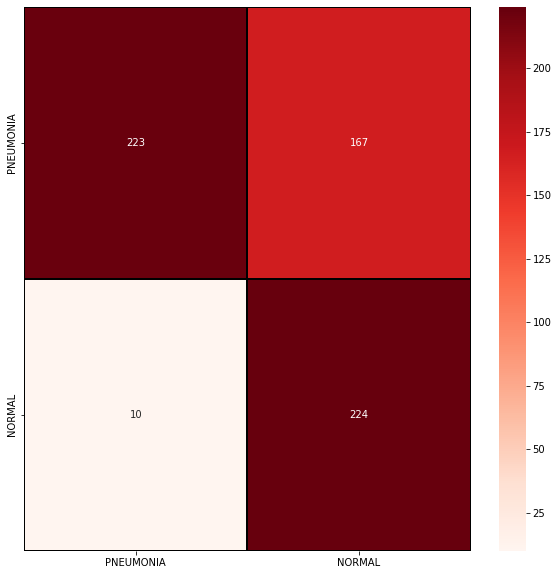

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)